In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

In [ ]:
co2_df = pd.read_csv("/content/co2_mm_gl.csv")

co2_df = co2_df[['year', 'month', 'average']]
co2_df['day'] = 1

co2_df['date'] = pd.to_datetime(co2_df[['year', 'month', 'day']])
co2_df = co2_df.set_index('date')

co2_df = co2_df.rename(columns={'average': 'co2_ppm'})
co2_df = co2_df[['co2_ppm']]

In [ ]:
soi_df = pd.read_excel("/content/SOI_dataset.xlsx")

soi_df = soi_df[['year', 'month', 'soi']]
soi_df['day'] = 1

soi_df['date'] = pd.to_datetime(soi_df[['year', 'month', 'day']])
soi_df = soi_df.set_index('date')
soi_df = soi_df[['soi']]
soi_df['soi'] = pd.to_numeric(soi_df['soi'], errors='coerce')

In [ ]:
all_data = pd.concat([co2_df, soi_df], axis=1, join='inner')
all_data.head()
all_data.isnull().sum()

,0
co2_ppm,0
soi,0


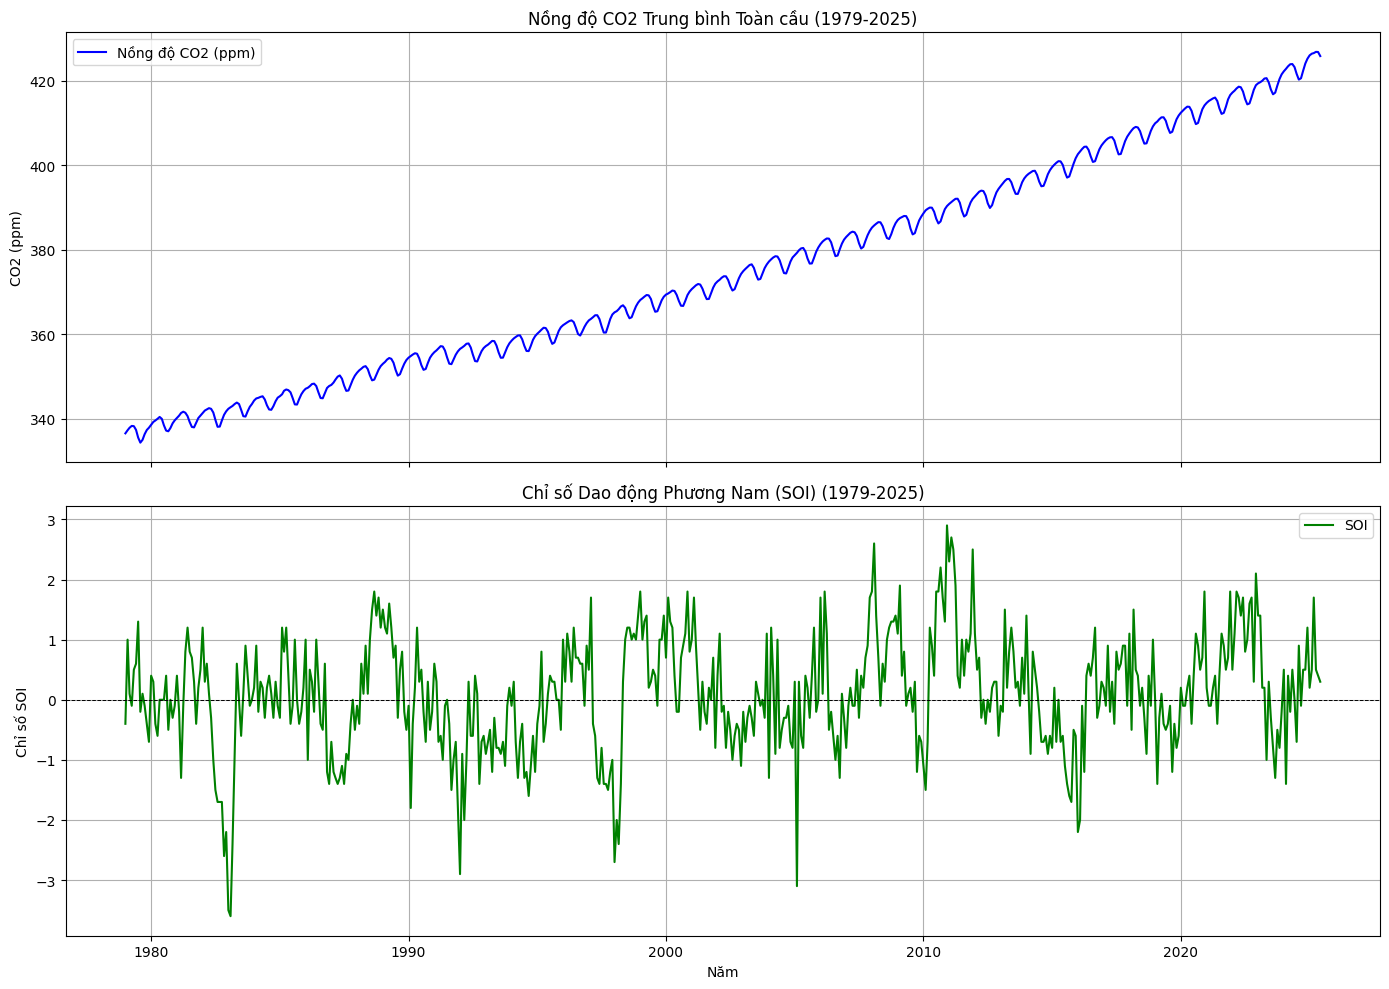

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(all_data.index, all_data['co2_ppm'], label='Nồng độ CO2 (ppm)', color='b')
ax1.set_ylabel('CO2 (ppm)')
ax1.set_title('Nồng độ CO2 Trung bình Toàn cầu (1979-2025)')
ax1.legend()
ax1.grid(True)

ax2.plot(all_data.index, all_data['soi'], label='SOI', color='g')
ax2.set_ylabel('Chỉ số SOI')
ax2.set_title('Chỉ số Dao động Phương Nam (SOI) (1979-2025)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.7)
ax2.legend()
ax2.grid(True)

plt.xlabel('Năm')
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"--- Đánh giá {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE:  {mape:.4f}")
    return mse, rmse, mae, mape

In [ ]:
def plot_results(train_data, test_data, predictions, model_name):
    plt.figure(figsize=(15, 7))
    plt.plot(train_data.index, train_data, label='Dữ liệu Training')
    plt.plot(test_data.index, test_data, label='Dữ liệu Testing', color='orange')
    plt.plot(predictions.index, predictions, label=f'Dự đoán {model_name}', color='green', linestyle='--')
    plt.title(f'Dự đoán nồng độ CO2 - Mô hình {model_name}')
    plt.xlabel('Ngày')
    plt.ylabel('Nồng độ CO2 (ppm)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def create_dataset_univariate(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def create_dataset_multivariate(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
def recursive_forecast_univariate(model, start_window, n_steps):
    predictions = []
    current_window = start_window.reshape((1, TIME_STEP, 1))

    for _ in range(n_steps):
        pred = model.predict(current_window, verbose=0)[0,0]
        predictions.append(pred)
        new_window = np.append(current_window[0, 1:, 0], pred)
        current_window = new_window.reshape((1, TIME_STEP, 1))

    return np.array(predictions)

def recursive_forecast_multivariate(model, start_window, future_exog_scaled, n_steps):
    predictions = []
    current_window = start_window.reshape((1, TIME_STEP, 2)) # Shape (1, 12, 2)

    for i in range(n_steps):
        pred_resid_scaled = model.predict(current_window, verbose=0)[0,0]
        predictions.append(pred_resid_scaled)

        next_soi_scaled = future_exog_scaled[i, 0]

        new_entry = np.array([pred_resid_scaled, next_soi_scaled]).reshape((1, 2))

        new_window_data = np.append(current_window[0, 1:, :], new_entry, axis=0)

        current_window = new_window_data.reshape((1, TIME_STEP, 2))

    return np.array(predictions)

In [ ]:
TEST_SIZE = 111
TIME_STEP = 12
EPOCHS = 100
BATCH_SIZE = 16

In [ ]:
def load_and_prepare_data(co2_file, soi_file):
    try:
        df_co2 = pd.read_csv(co2_file, comment='#')
        df_co2 = df_co2[['year', 'month', 'average']]
        df_co2.rename(columns={'average': 'co2'}, inplace=True)

        df_soi = pd.read_csv(soi_file)
        df_soi = df_soi[['year', 'month', 'soi']]

        df_combined = pd.merge(df_co2, df_soi, on=['year', 'month'], how='inner')

        df_combined = df_combined.interpolate(method='time')
        df_combined = df_combined.fillna(method='ffill')
        df_combined = df_combined.fillna(method='bfill')

        df_combined['date'] = pd.to_datetime(df_combined['year'].astype(str) + '-' + df_combined['month'].astype(str) + '-01')
        df_combined = df_combined.set_index('date')
        df_final = df_combined[['co2', 'soi']].sort_index()
        df_final = df_final.loc['1979-01-01':'2025-06-01']

        if df_final.empty:
             print("Lỗi: Dữ liệu bị rỗng.")
             sys.exit()

        return df_final

    except FileNotFoundError as e:
        print(f"Lỗi: Không tìm thấy file. Chắc chắn rằng tên file là chính xác.")
        print(e)
        sys.exit()
    except Exception as e:
        print(f"Lỗi khi tải dữ liệu: {e}")
        sys.exit()

In [ ]:
train_data = all_data.iloc[:-TEST_SIZE]
test_data = all_data.iloc[-TEST_SIZE:]
y_test_ground_truth = test_data['co2_ppm'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("--- 1. Bắt đầu Mô hình Hybrid SARIMA-LSTM (Đơn biến) ---")

best_order = (4, 1, 3)
best_seasonal_order = (1, 1, 1, 12)
model_sarima = SARIMAX(train_data['co2_ppm'], order=best_order, seasonal_order=best_seasonal_order)
sarima_results = model_sarima.fit(disp=False)
print("   Huấn luyện SARIMA (Base) hoàn tất.")

train_residuals_uni = sarima_results.resid.values
scaler_resid_uni = MinMaxScaler(feature_range=(0, 1))
train_resid_uni_scaled = scaler_resid_uni.fit_transform(train_residuals_uni.reshape(-1, 1))

X_train_lstm_uni, y_train_lstm_uni = create_dataset_univariate(train_resid_uni_scaled, TIME_STEP)
X_train_lstm_uni = X_train_lstm_uni.reshape(X_train_lstm_uni.shape[0], X_train_lstm_uni.shape[1], 1)

--- 1. Bắt đầu Mô hình Hybrid SARIMA-LSTM (Đơn biến) ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Huấn luyện SARIMA (Base) hoàn tất.


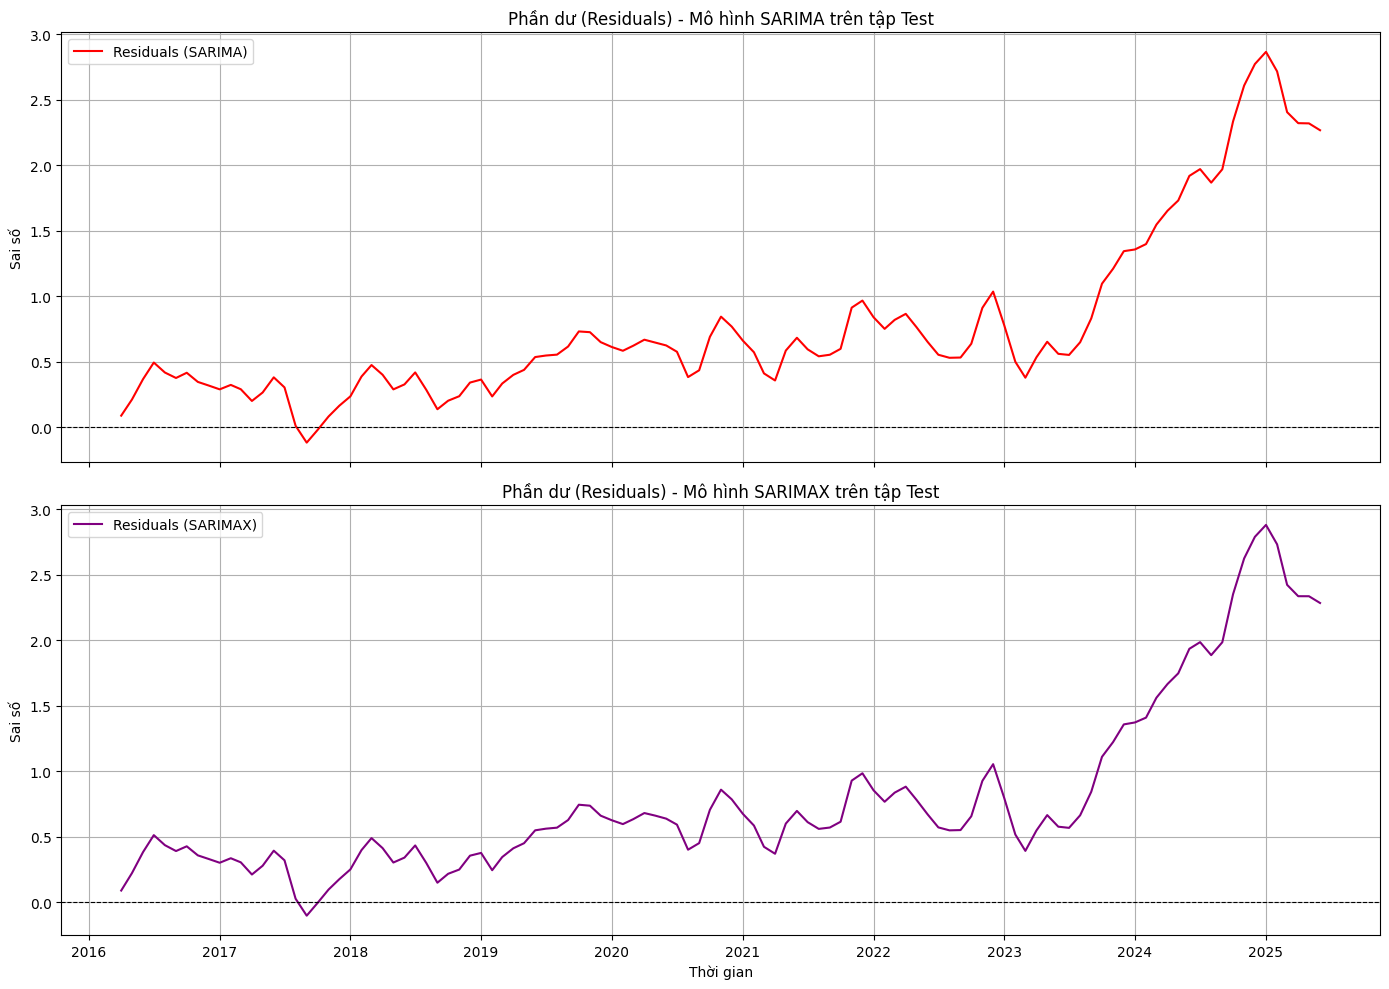

In [ ]:
sarima_test_forecast = sarima_results.get_forecast(steps=TEST_SIZE).predicted_mean
residuals_test_sarima = test_data['co2_ppm'] - sarima_test_forecast

sarimax_test_forecast = sarimax_results.get_forecast(steps=TEST_SIZE, exog=test_data['soi']).predicted_mean
residuals_test_sarimax = test_data['co2_ppm'] - sarimax_test_forecast


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(residuals_test_sarima.index, residuals_test_sarima, label='Residuals (SARIMA)', color='red')
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.set_title('Phần dư (Residuals) - Mô hình SARIMA trên tập Test')
ax1.set_ylabel('Sai số')
ax1.legend()
ax1.grid(True)

ax2.plot(residuals_test_sarimax.index, residuals_test_sarimax, label='Residuals (SARIMAX)', color='purple')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_title('Phần dư (Residuals) - Mô hình SARIMAX trên tập Test')
ax2.set_ylabel('Sai số')
ax2.legend()
ax2.grid(True)

plt.xlabel('Thời gian')
plt.tight_layout()
plt.show()

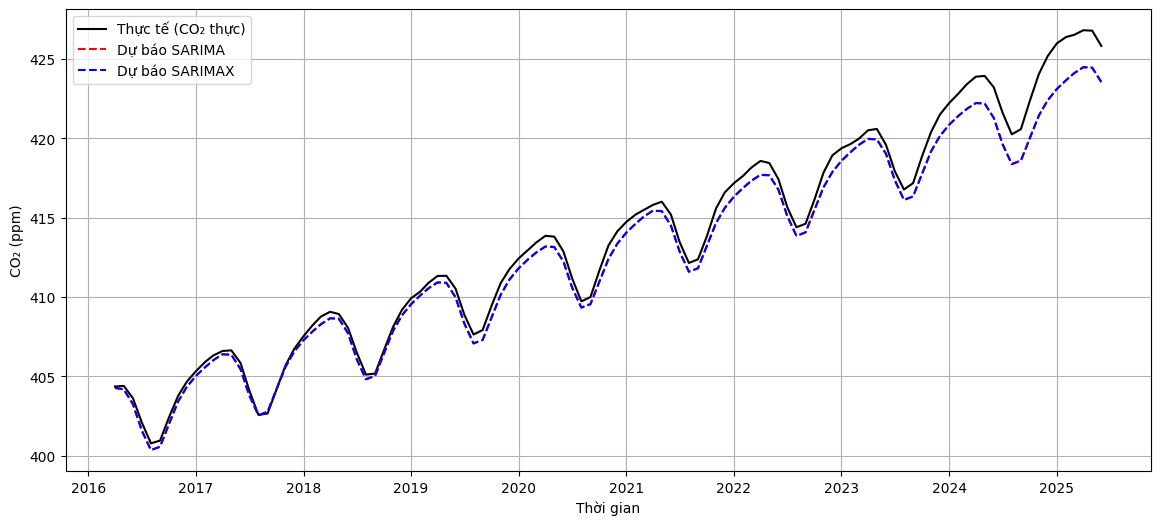

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['co2_ppm'], label='Thực tế (CO₂ thực)', color='black')
plt.plot(test_data.index, sarima_test_forecast, label='Dự báo SARIMA', color='red', linestyle='--')
plt.plot(test_data.index, sarimax_test_forecast, label='Dự báo SARIMAX', color='blue', linestyle='--')
plt.title('')
plt.xlabel('Thời gian')
plt.ylabel('CO₂ (ppm)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_lstm_uni = Sequential([
    LSTM(30, input_shape=(TIME_STEP, 1)),
    Dropout(0.2),
    Dense(1)
])
model_lstm_uni.compile(optimizer='adam', loss='mean_squared_error')
model_lstm_uni.fit(X_train_lstm_uni, y_train_lstm_uni,
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                    callbacks=[EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)])
print("   Huấn luyện LSTM (Đơn biến) trên Lỗi hoàn tất.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Huấn luyện LSTM (Đơn biến) trên Lỗi hoàn tất.


In [ ]:
sarima_forecast = sarima_results.get_forecast(steps=TEST_SIZE).predicted_mean.values
start_window_uni = train_resid_uni_scaled[-TIME_STEP:]
lstm_resid_forecast_scaled = recursive_forecast_univariate(model_lstm_uni, start_window_uni, TEST_SIZE)
lstm_resid_forecast_uni = scaler_resid_uni.inverse_transform(lstm_resid_forecast_scaled.reshape(-1, 1)).flatten()

hybrid_forecast_uni = sarima_forecast + lstm_resid_forecast_uni

In [ ]:
print("\n--- 2. Bắt đầu Mô hình Hybrid SARIMAX-LSTM (Đa biến) ---")

model_sarimax = SARIMAX(train_data['co2_ppm'], exog=train_data['soi'],
                        order=best_order, seasonal_order=best_seasonal_order)
sarimax_results = model_sarimax.fit(disp=False)
print("   Huấn luyện SARIMAX (Base) hoàn tất.")

train_residuals_multi = sarimax_results.resid.values.reshape(-1, 1)
train_soi = train_data['soi'].values.reshape(-1, 1)

scaler_resid_multi = MinMaxScaler(feature_range=(0, 1))
scaler_soi_multi = MinMaxScaler(feature_range=(0, 1))

train_resid_scaled = scaler_resid_multi.fit_transform(train_residuals_multi)
train_soi_scaled = scaler_soi_multi.fit_transform(train_soi)

train_data_multi_scaled = np.hstack((train_resid_scaled, train_soi_scaled))

test_soi_scaled = scaler_soi_multi.transform(test_data['soi'].values.reshape(-1, 1))

X_train_lstm_multi, y_train_lstm_multi = create_dataset_multivariate(train_data_multi_scaled, TIME_STEP)


--- 2. Bắt đầu Mô hình Hybrid SARIMAX-LSTM (Đa biến) ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Huấn luyện SARIMAX (Base) hoàn tất.


In [ ]:
model_lstm_multi = Sequential([
    LSTM(30, input_shape=(TIME_STEP, 2)),
    Dropout(0.2),
    Dense(1)
])
model_lstm_multi.compile(optimizer='adam', loss='mean_squared_error')
model_lstm_multi.fit(X_train_lstm_multi, y_train_lstm_multi,
                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                      callbacks=[EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)])
print("   Huấn luyện LSTM (Đa biến) trên Lỗi hoàn tất.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Huấn luyện LSTM (Đa biến) trên Lỗi hoàn tất.


In [ ]:
sarimax_forecast = sarimax_results.get_forecast(steps=TEST_SIZE, exog=test_data['soi']).predicted_mean.values

start_window_multi = train_data_multi_scaled[-TIME_STEP:]

lstm_resid_forecast_scaled = recursive_forecast_multivariate(model_lstm_multi, start_window_multi, test_soi_scaled, TEST_SIZE)

lstm_resid_forecast_multi = scaler_resid_multi.inverse_transform(lstm_resid_forecast_scaled.reshape(-1, 1)).flatten()

hybrid_forecast_multi = sarimax_forecast + lstm_resid_forecast_multi


--- TỔNG KẾT SO SÁNH (GIAI ĐOẠN 6: HYBRID-LSTM) ---
SARIMA (Base)          | RMSE: 1.0187  | MAE: 0.7774  | MSE: 1.0377  | MAPE: 0.0019 
SARIMA-LSTM (Đơn biến)  | RMSE: 4.0237  | MAE: 3.9642  | MSE: 16.1898 | MAPE: 0.0096 
SARIMAX-LSTM (Đa biến) | RMSE: 1.7629  | MAE: 1.6458  | MSE: 3.1079  | MAPE: 0.0040 

==> KẾT LUẬN: SARIMA (Base) vẫn là mô hình tốt nhất.
    Việc thêm LSTM để mô hình hóa Lỗi không cải thiện kết quả (do Lỗi đã là nhiễu).


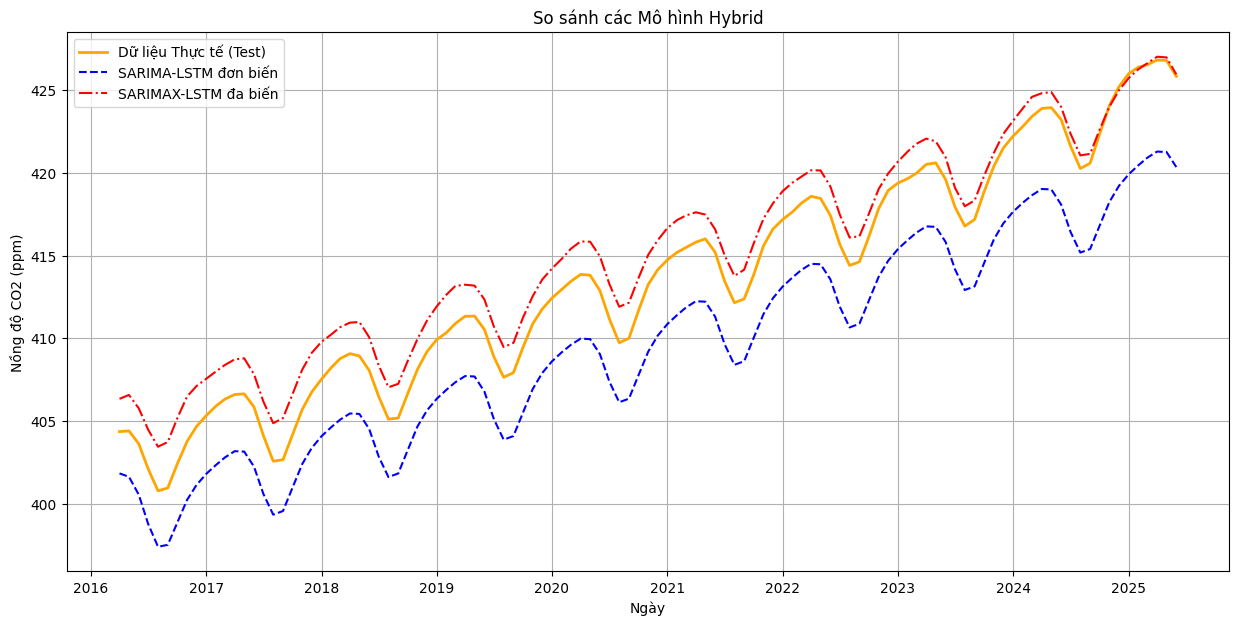

In [ ]:
print("\n" + "="*30)
print("--- TỔNG KẾT SO SÁNH (GIAI ĐOẠN 6: HYBRID-LSTM) ---")
print("="*30)

rmse_sarima_base = np.sqrt(mean_squared_error(y_test_ground_truth, sarima_forecast))
mae_sarima_base = mean_absolute_error(y_test_ground_truth, sarima_forecast)
mse_sarima_base = mean_squared_error(y_test_ground_truth, sarima_forecast)
mape_sarima_base = mean_absolute_percentage_error(y_test_ground_truth, sarima_forecast)

rmse_hybrid_uni = np.sqrt(mean_squared_error(y_test_ground_truth, hybrid_forecast_uni))
mae_hybrid_uni = mean_absolute_error(y_test_ground_truth, hybrid_forecast_uni)
mse_hybrid_uni = mean_squared_error(y_test_ground_truth, hybrid_forecast_uni)
mape_hybrid_uni = mean_absolute_percentage_error(y_test_ground_truth, hybrid_forecast_uni)

rmse_hybrid_multi = np.sqrt(mean_squared_error(y_test_ground_truth, hybrid_forecast_multi))
mae_hybrid_multi = mean_absolute_error(y_test_ground_truth, hybrid_forecast_multi)
mse_hybrid_multi = mean_squared_error(y_test_ground_truth, hybrid_forecast_multi)
mape_hybrid_multi = mean_absolute_percentage_error(y_test_ground_truth, hybrid_forecast_multi)

print(f"SARIMA (Base)          | RMSE: {rmse_sarima_base:<7.4f} | MAE: {mae_sarima_base:<7.4f} | MSE: {mse_sarima_base:<7.4f} | MAPE: {mape_sarima_base:<7.4f}")
print(f"SARIMA-LSTM (Đơn biến)  | RMSE: {rmse_hybrid_uni:<7.4f} | MAE: {mae_hybrid_uni:<7.4f} | MSE: {mse_hybrid_uni:<7.4f} | MAPE: {mape_hybrid_uni:<7.4f}")
print(f"SARIMAX-LSTM (Đa biến) | RMSE: {rmse_hybrid_multi:<7.4f} | MAE: {mae_hybrid_multi:<7.4f} | MSE: {mse_hybrid_multi:<7.4f} | MAPE: {mape_hybrid_multi:<7.4f}")
print("="*30)

best_rmse = min(rmse_sarima_base, rmse_hybrid_uni, rmse_hybrid_multi)

if best_rmse == rmse_sarima_base:
    print("\n==> KẾT LUẬN: SARIMA (Base) vẫn là mô hình tốt nhất.")
    print("    Việc thêm LSTM để mô hình hóa Lỗi không cải thiện kết quả (do Lỗi đã là nhiễu).")
elif best_rmse == rmse_hybrid_uni:
    print("\n==> KẾT LUẬN: SARIMA-LSTM (Đơn biến) là mô hình tốt nhất!")
else:
    print("\n==> KẾT LUẬN: SARIMAX-LSTM (Đa biến) là mô hình tốt nhất!")

plt.figure(figsize=(15, 7))
plt.plot(test_data.index, y_test_ground_truth, label='Dữ liệu Thực tế (Test)', color='orange', linewidth=2)
plt.plot(test_data.index, hybrid_forecast_uni, label=f'SARIMA-LSTM đơn biến', color='blue', linestyle='--')
plt.plot(test_data.index, hybrid_forecast_multi, label=f'SARIMAX-LSTM đa biến', color='red', linestyle='-.')
plt.title('So sánh các Mô hình Hybrid')
plt.xlabel('Ngày')
plt.ylabel('Nồng độ CO2 (ppm)')
plt.legend()
plt.grid(True)
plt.show()